In [1]:
import pandas as pd
from math import sqrt 
import numpy as np
import functools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
from IPython.display import clear_output
import sys
python_modules = input('path to python_modules ')
if python_modules =='':
    python_modules = '/home/skw24/python_modules'
sys.path.append(python_modules)
import bacteria2
                
import json

#### Purpose
The purpose of this notebook is to compare our generated mutational signatures stored at global_results_path('median_signatures.csv') against those generated by "A Compendium of Mutational Signatures of Environmental Agents". 

#### Preparatory steps

For each of the bacteria automatic.ipynb should be run to generate the mutational fingers. 

The bacterial signatures are available here as 'tog_mut_sigs.csv'
These should be downloaded and saved as /results/tog_mut_sigs.csv

A further file 'median_signatures.csv' is also available which provides the median bacterial signatures for clustered signatures. 
Again this should be downloaded and saved as 
/results/median_signatures.csv relative to this workbook.

The mutational fingerprints for the mutagens are available and can be downloaded from https://signal.mutationalsignatures.com/explore/mutagens?group&hasSignature=true&name=
and saved in the datapath (change the cell datapath= below to path of your choice)

The human genome is needed to identify the background trinucleotide count. The chromosomes can be downloaded from ftp://ftp.ensembl.org/pub/release-100/fasta/homo_sapiens/dna/
should be unzipped and then saved in the datapath as 
'Homo_sapiens.GRCh38.dna.chromosome.{}.seq'.format(i)
where i runs from 1 to 23.

#### Overview

firstly - normalise the mutationalsignatures by 
the probability vector that would be achieved if all missense mutations were equally likely.

secondly - finding the cosine similarity of the mutationalsignatures against our bacterial signatures.

thirdly - looking for the pvalue for these signatures by randomly shuffling the bacterial channels



In [2]:
datapath = input('path to your data on the chromosomes ')
if datapath = '':
    datapath ='../Data1'

mutagen_path = input(
    'path to the save mutagenesis_signature_data ')
if mutagen_path = '':
    mutagen_path = os.path.join(datapath,
                  'mutagenesis_signature_data.csv')

In [3]:
if not os.path.isdir('results'):
    os.mkdir('results')
    
global_results_path = lambda string: os.path.join(os.getcwd(),
                                                 'results',
                                                 string)
def cos_sim(a,b):
    norm = lambda x: x/sqrt((x*x).sum())
    return (norm(a)*norm(b)).sum()

In [4]:
# load our pre-existing bacterial signatures

bacsigs = pd.read_csv(global_results_path('median_signatures.csv'),
                     index_col = 0)

In [ ]:
# identify the background codon count in the human genome.
index = [i+j+k for i in 'ACGT' for j in 'ACGT' for k in 'ACGT']
counts = pd.Series(0,index = index)

for i in range(1,24):
    file = 'Homo_sapiens.GRCh38.dna.chromosome.{}.seq'.format(i)
    path = os.path.join(datapath,file)
    with open(path) as f:
        ch = f.read()
    # we simply knock out all unidentified patches - the extent
    # of the error introduced is negligible
    ch = ch.replace('N','')
    gen =(ch[i:i+3] for i in range(len(ch)-3))
    j=0
    while True:
        j+=1
        try:
            counts[next(gen)]+=1
            if j%1000000==0:
                print('ch{} {}'.format(i,j))
                clear_output(wait = True)
                counts['finished'] = int(str(j)+
                                         '{0:02d}'.format(i))
                counts.to_csv('hs_counts.csv',
                              header = False)
                            
        except StopIteration:
            counts['finished'] = i
            counts.to_csv('hs_counts.csv',
                              header = False)
            break
        

In [ ]:
def convert_to_quads():
    '''convert the homo_sapiens background codon count into our 
    familiar quadruplets_sorted
    '''
    
    hs_counts = pd.read_csv('hs_counts.csv', 
                header = None,
               squeeze = True,
               index_col = 0)[:-1]

    s0 = pd.concat([hs_counts for i in range(4)])
    def get_quad(i):
        extra = 'ACGT'[i//64]
        trip = s0.index[i]
        return ''.join([trip[0],trip[1],extra,trip[2]])
    s0.index = [get_quad(i) for i in range(256)]
    s1 =pd.DataFrame(s0[[i for i in s0.index if i[1]!=i[2]]])
    s1['ct'] = s1.index.map(bacteria2.ct)
    s = s1.groupby(by = 'ct').sum()[1].reindex(
        bacteria2.quadruplets_sorted)
    whole_genome_background_quads = 100*s/s.sum()
    whole_genome_background_quads.to_csv(
        'whole_genome_background_quads.csv',
        header = False)
    return whole_genome_background_quads,hs_counts


In [ ]:
whole_genome_background_quads,hs_counts = convert_to_quads()


In [5]:
whole_genome_background_quads=pd.read_csv(
    'whole_genome_background_quads.csv',
    header = None,
    index_col = 0,
    squeeze = True)

visualise the whole_genome_background_quads

In [ ]:
fig,ax = plt.subplots()
bacteria2.plot_quads(whole_genome_background_quads,ax = ax)
fig.savefig('whole_genome_background.pdf')


visualise the whole genome background trinucleotides

In [ ]:
hs_percs = 100*hs_counts/hs_counts.sum()
trip_sort = lambda x: x[1]+x[0]+x[2]

sorted_index = pd.Series(hs_percs.index.map(trip_sort),
          index = hs_percs.index).sort_values().index
fig,ax = plt.subplots(figsize = (15,3))
hs_percs.reindex(sorted_index).plot(kind = 'bar',ax = ax)
ax.set_title('% whole exome codons')
ax.set_ylabel('% composition')
ax.set_xlabel('codon');

fig.savefig('perc_whole_exome_codons.pdf')

In [32]:
# load the mutagenic signatures, put them in alphabetical order and
# then normalise by whole_genome_background

mutagen_sigs = pd.read_csv(mutagen_path,index_col = 0)

mutagen_sigs=mutagen_sigs[mutagen_sigs.columns.sort_values()]

mutagen_sigs.index = bacteria2.quadruplets_sorted

whole_genome_background_quads/=whole_genome_background_quads.sum()

ms01 = mutagen_sigs.apply(lambda col: col/
                          whole_genome_background_quads)

ms = ms01.apply(lambda col: 100*col/col.sum())

In [6]:
def show_all_sigs(ms,cols,width):
    
    '''Show all the 96 long vectors of ms as a set of 
    colored bar charts. The width of each chart is given by width
    and the number of cols shown in a single row by cols.
    '''
    mx = ms.max().max()
    fignum = ms.shape[1]
    rows = fignum//cols
    if rows*cols<fignum:
        rows+=1

    fig,axarr = plt.subplots(rows,cols,
                             figsize = (width*cols,0.75*width*rows))
    for i in range(fignum):
        ax = axarr[i//cols][i%cols]
        bacteria2.plot_quads(ms.iloc[:,i],ax=ax)
        ax.set_title(ms.columns[i])
        ax.set_ylim(0,mx)
    for i in range(fignum,rows*cols):
        ax = axarr[i//cols][i%cols]
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()
    return fig

In [ ]:
show_all_sigs(mutagen_sigs,6,3.5)

In [ ]:
fig = show_all_sigs(ms,6,3.5)

In [ ]:
fig.savefig(global_results_path('mutagensigs.pdf'))

In [ ]:
def get_worth_checking(bs,ms):
    '''find the cosine similarity of each column of bs
    against each column of each ms. Returns dataframe of
    those entries with similarity >0.5.
    
    Anything below that will not be statistically significant.
    '''
    
    cs_of_bac_mut = pd.DataFrame()

    columns = ['bacsig','mutagen','cos_sim']

    i = -1
    for name1 in bs.columns:
        bacsig = bs[name1]
        for name2 in ms.columns:
            mutagensig = ms[name2]
            i+=1
            s = pd.Series([name1,name2, cos_sim(bacsig,mutagensig)],
                         index = columns,name = i)
            cs_of_bac_mut = cs_of_bac_mut.append(s)

    cs_sorted = cs_of_bac_mut.sort_values(by = 'cos_sim',
                             ascending = False)[['bacsig','mutagen',
                                                 'cos_sim']]

    cs_ok = cs_sorted.loc[cs_sorted['cos_sim']>0.5]
    return cs_ok

In [10]:
tog_bacsigs = pd.read_csv(global_results_path('tog_mut_sigs.csv')
                                        ,index_col = 0)

In [ ]:
cs_ok_all_bacsigs = get_worth_checking(tog_bacsigs,ms)

cs_ok_all_bacsigs = cs_ok_all_bacsigs.sort_values(
    by = ['mutagen','cos_sim'])

cs_ok_all_bacsigs.index = range(cs_ok_all_bacsigs.shape[0])

In [ ]:
cs_ok_all_bacsigs.shape

In [7]:
def formatp(p):
    if p==0:
        return '<1.00E-04'
    else:
        return '{:.2E}'.format(p)

def plural(n):
    if n==1:
        return ' is'
    else:
        return 's are'

In [94]:
def show_stat_sig_mutagen(g,bacsigs,mu_with_parsed_bacs,
                          start=0,stop=0):
    
    '''Given a dataframe g which gives the bacsig name, 
    mutsig name,cosine value, and potentially the pvalue, 
    shows the corresponding mutational signatures side by side.
    
    Inputs:
    
    g - dataframe with columns 'bacsig','mutagen','cos_sim' and
    pvalue
    
    vc - lookup dataframe to find how many bacterial signatures
    are similar to the mutagenic signature.
  
    bacsigs - look up dataframe to find the bacsig vector
    (note that the mutsig one is found automatically from ms.)
    
    start=0 these dataframes can be long so optionally particular
    rows can be chosen.
    
    stop=0
    
    Outputs:
    return a plt.Figure
    
    '''
    inc_pvalue = ('pvalue' in g.columns)
    
    if inc_pvalue:
        g = g[['bacsig','mutagen','cos_sim','pvalue']]
    else:
        g = g[['bacsig','mutagen','cos_sim']]
    
    width = 5
    height = 3
    cols = 3
    if stop ==0:
        stop = g.shape[0]
    rows = stop-start
        
    fig,axarr = plt.subplots(rows,cols,
                             figsize = (cols*width,
                                        rows*height))

    for j in range(start,stop):
        i = j-start
        if inc_pvalue:
            b,m,c,p= g.iloc[j]
        else:            
            b,m,c= g.iloc[j]
        v = vc[m]
        ax = axarr[i][0]
        bacteria2.plot_quads(bacsigs[b],ax = ax)
        ax.set_title(b)
        ax = axarr[i][1]
        bacteria2.plot_quads(ms[m],ax = ax)
        ax.set_title(m)
        ax = axarr[i][2]
        text = '''
Similar signatures to {} occur in 
{}
The best is {} 
with cosine value = {:.2f}
adjusted pvalue {}'''.format(m,mu_with_parsed_bacs[m]
                                     ,b,c,formatp(p))
        ax.text(0.1,0.2,text)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    return fig


the outpath for the median signatures is 'mutagenic_pvalues.csv'
for all of the signatures is 'tot_mutagenic_pvalues.csv'

In [ ]:
def get_pvalue(i,df,bacsigs,ms,outpath,niters = 10000):
    '''
    performs a number of iterations to determine a pvalue
    
    Inputs
    i - the number row to deal with
    
    df - dataframe giving a bacsig name, a mutsig name,
    cosine similarity
    
    
    bacsigs - lookup dataframe to find the bacsig
    ms-lookup dataframe to find the mutsig
    
    outpath - path to save the resulting information
    niters- number of iterations to perform
    
    Output - a line of text is appended to the outpath 
    giving bacsig name, mutsig name, cosine similarity and pvalue 
    
    NOTE - this function creates a tsv not a csv as commas are 
    included in the names of the mutagens eg 1,6-DNP (0.09 uM)
    
    '''
    
    if not os.path.isfile(outpath):
        with open(outpath,'w') as f:
            f.write('bacsig\tmutagen\tcos_sim\tpvalue\n')
    b,m,c = df.iloc[i]
    bacsig, mutsig = bacsigs[b].copy(),ms[m]

    def random_cs(j):
        np.random.shuffle(bacsig)
        if j%500==0:
            print(j,'', end = ' ')
        return cos_sim(bacsig,mutsig)

    randoms = [random_cs(j) for j in range(1,niters+1)]
    high_low_randoms = sorted(randoms)[::-1]
    
    try:
        pvalue = next((i for i in range(niters) if 
                       high_low_randoms[i]<c))/niters
        
    except StopIteration:
        pvalue= 1.0
        

    row = '{}\t{}\t{}\t{}\n'.format(b,m,c,pvalue)
    print('{} of {}'.format(i,df.shape[0]))
    print(row)
    with open(outpath,'a') as f:
        f.write(row)
    return pvalue
        

In [ ]:
#generate the p values for all the bacsigs.
for i in range(cs_ok_all_bacsigs.shape[0]):

    get_pvalue(i,cs_ok_all_bacsigs,
               tog_bacsigs,
               ms,'tot_mutagenic_pvalues.tsv',
               niters = 10000)


In [ ]:
with open('tot_mutagenic_pvalues.csv') as f:
    g=f.read().split('\n')[:-1]

In [ ]:
def comma_split(i):

    j = i.split(',')

    return [j[0],','.join(j[1:-2]),j[-2],j[-1]]

In [ ]:
df = pd.DataFrame([comma_split(row) for row in g[1:]])

In [ ]:
df.columns = comma_split(g[0])

In [ ]:
df.to_csv('tot_mutagenic_pvalues.tsv',sep = '\t')

In [9]:
df = pd.read_csv('tot_mutagenic_pvalues.tsv',sep = '\t',
                index_col = 0)

df =df.sort_values(by = 'pvalue')

df['bh'] = pd.Series(range(1,304),
                     index = df.index)*df['pvalue']

df_good = df.loc[df['bh']<0.05]

In [ ]:
tog_bacsigs.shape

In [ ]:
df_good.shape

In [11]:
vc = df_good['mutagen'].value_counts()

In [12]:
vc

MNU (350 uM)                    24
Temozolomide (200 uM).1         23
Temozolomide (200 uM)           21
ENU (400 uM)                    15
DMH (11.6 mM) + S9              15
Mechlorethamine (0.3 uM)         6
Propylene oxide (10 mM)          6
DES (0.938 mM)                   3
PhIP (4 uM) + S9                 3
PhIP (3 uM) + S9                 3
DMS (0.078 mM)                   1
Ellipticine (0.375 uM) + S9      1
AAI (1.25 uM)                    1
MX (7 uM) + S9                   1
N-Nitrosopyrrolidine (50 mM)     1
BPDE (0.125 uM)                  1
Benzidine (200 uM)               1
Name: mutagen, dtype: int64

In [14]:
mutagens = set(df_good['mutagen'])

In [15]:
mutagens

{'AAI (1.25 uM)',
 'BPDE (0.125 uM)',
 'Benzidine (200 uM)',
 'DES (0.938 mM)',
 'DMH (11.6 mM) + S9',
 'DMS (0.078 mM)',
 'ENU (400 uM)',
 'Ellipticine (0.375 uM) + S9',
 'MNU (350 uM)',
 'MX (7 uM) + S9',
 'Mechlorethamine (0.3 uM)',
 'N-Nitrosopyrrolidine (50 mM)',
 'PhIP (3 uM) + S9',
 'PhIP (4 uM) + S9',
 'Propylene oxide (10 mM)',
 'Temozolomide (200 uM)',
 'Temozolomide (200 uM).1'}

In [48]:
def get_bacs_with_mu(mu):
    bacs_with_mu =df_good.loc[df_good['mutagen']==mu]['bacsig']

    return ', '.join(set(bacs_with_mu.map(
        lambda x:' '.join(x.split('_')[1:3]).capitalize())))

bacs_with_mu = pd.Series('',index = list(mutagens))
mutagen_list = list(mutagens)
v = map(get_bacs_with_mu, mutagen_list)
bacs_with_mu =pd.Series(v,index = mutagen_list)

In [78]:
def parse(x):
    y = x.split(',')
    sentence = ''
    length = 0
    for i in range(len(y)):
        length+=len(y[i])
        if length>55:
            length = len(y[i])

            sentence+= '\n'+y[i]+', '
        else:
            sentence+= y[i]+', '
    return sentence

In [81]:
mu_with_parsed_bacs = bacs_with_mu.map(parse)

In [102]:
mutagens

{'AAI (1.25 uM)',
 'BPDE (0.125 uM)',
 'Benzidine (200 uM)',
 'DES (0.938 mM)',
 'DMH (11.6 mM) + S9',
 'DMS (0.078 mM)',
 'ENU (400 uM)',
 'Ellipticine (0.375 uM) + S9',
 'MNU (350 uM)',
 'MX (7 uM) + S9',
 'Mechlorethamine (0.3 uM)',
 'N-Nitrosopyrrolidine (50 mM)',
 'PhIP (3 uM) + S9',
 'PhIP (4 uM) + S9',
 'Propylene oxide (10 mM)',
 'Temozolomide (200 uM)',
 'Temozolomide (200 uM).1'}

In [103]:
TC = ['Temozolomide (200 uM).1','MNU (350 uM)']
balanced = ['ENU (400 uM)','DMH (11.6 mM) + S9']

In [100]:
bacs_in_TC = df_good.loc[df_good['mutagen'].map(
    lambda x:x in TC)]['bacsig']

In [101]:
set(bacs_in_TC.map(lambda x:'_'.join(x.split('_')[1:3])))

{'burkholderia_pseudomallei',
 'enterococcus_faecalis',
 'escherichia_coli',
 'klebsiella_pneumoniae',
 'listeria_monocytogenes',
 'mycobacterium_abscessus',
 'mycobacterium_tuberculosis',
 'neisseria_gonorrhoeae',
 'pseudomonas_aeruginosa',
 'salmonella_enterica',
 'streptococcus_pneumoniae'}

In [25]:
vc.shape

(17,)

we find how many bacterial signatures are involved using

In [ ]:
bvc = df_good['bacsig'].value_counts()
print(bvc.shape)
bvc

In [ ]:
fig = show_all_sigs(ms,6,3.5)

In [ ]:
groups = pd.Series(df_good.groupby(by = 'bacsig').groups)

In [ ]:
mut_lists = groups.map(lambda x: list(df_good.reindex(x)['mutagen']))

In [ ]:
for m in mut_lists.index:
    print(m)
    print(', '.join(mut_lists[m]))

In [ ]:
bvc.index

In [26]:
df_good['1-cs'] = 1-df_good['cos_sim']

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_good.to_csv(global_results_path('cossims_for_mutagens.tsv'),
               sep = '\t')

In [28]:
df_best_matches = df_good.sort_values(by = ['pvalue','1-cs']).\
        drop_duplicates(subset =['mutagen'])

In [29]:
d = df_best_matches.iloc[:,[0,1,2,4]]
d.columns = list(d.columns[:-1])+['pvalue']

In [30]:
d.shape

(17, 4)

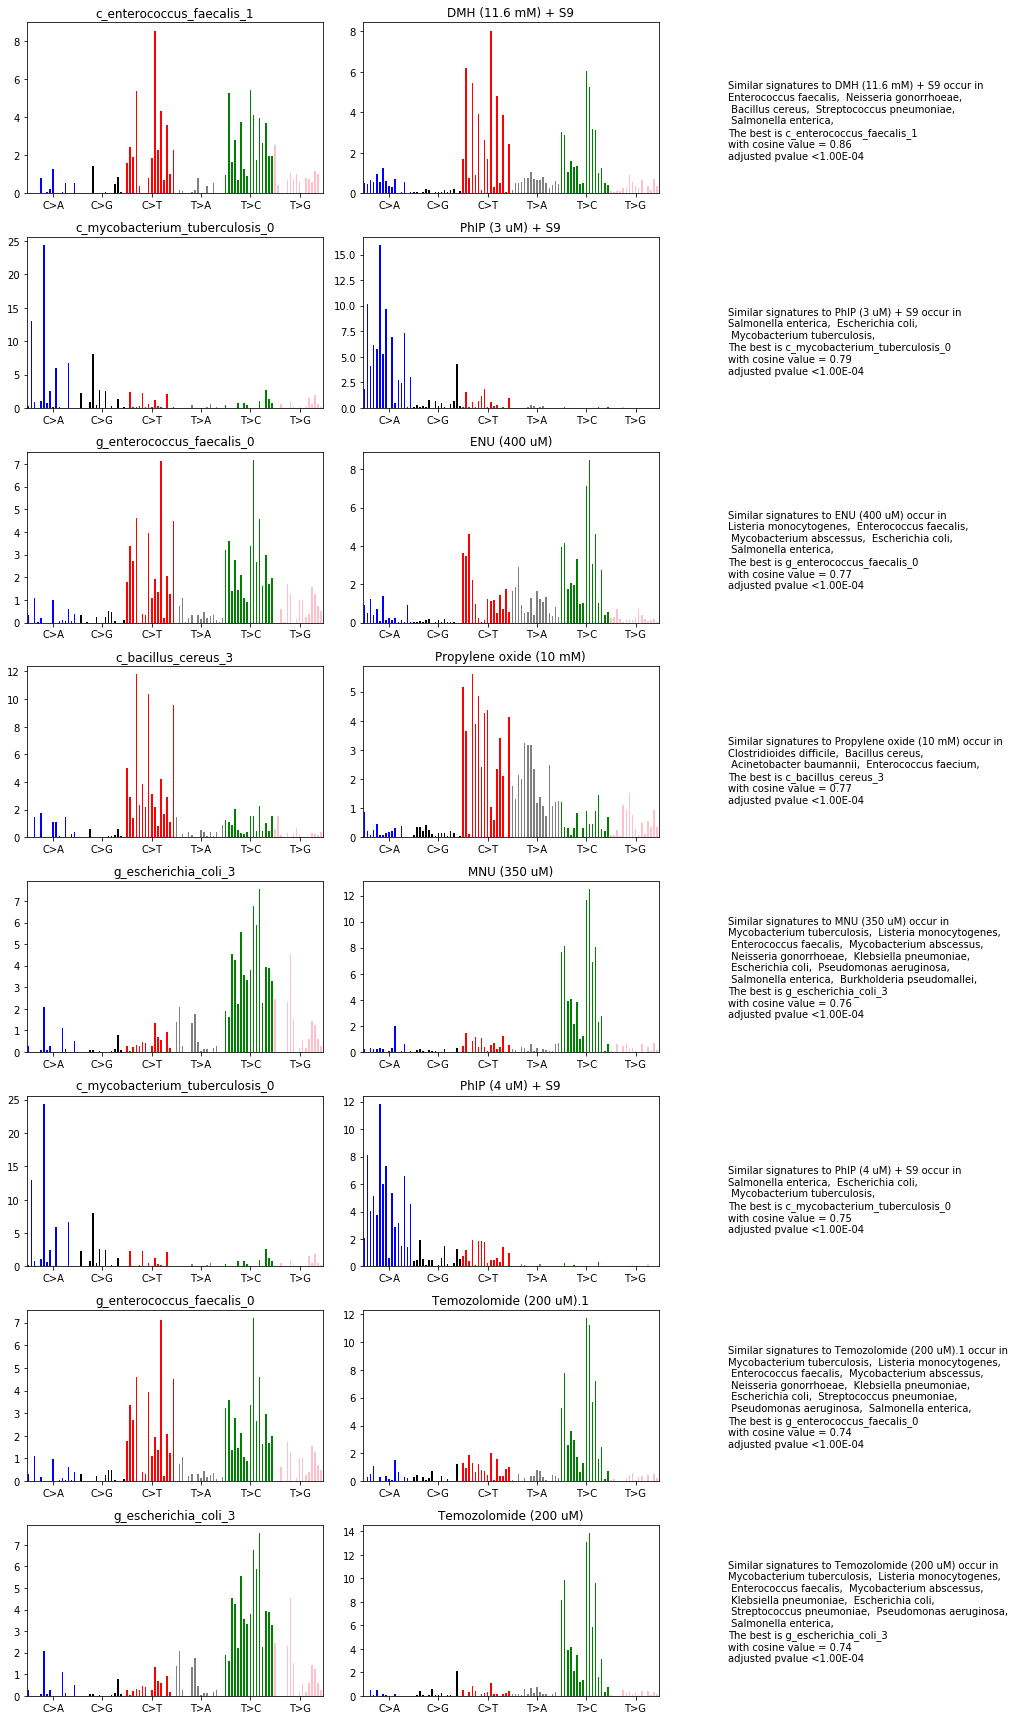

In [97]:
fig = show_stat_sig_mutagen(d,
                            tog_bacsigs*100,
                            mu_with_parsed_bacs,
                          start=0,stop=8)
fig.savefig(global_results_path('best_similarity_to_mutagens1.pdf'))

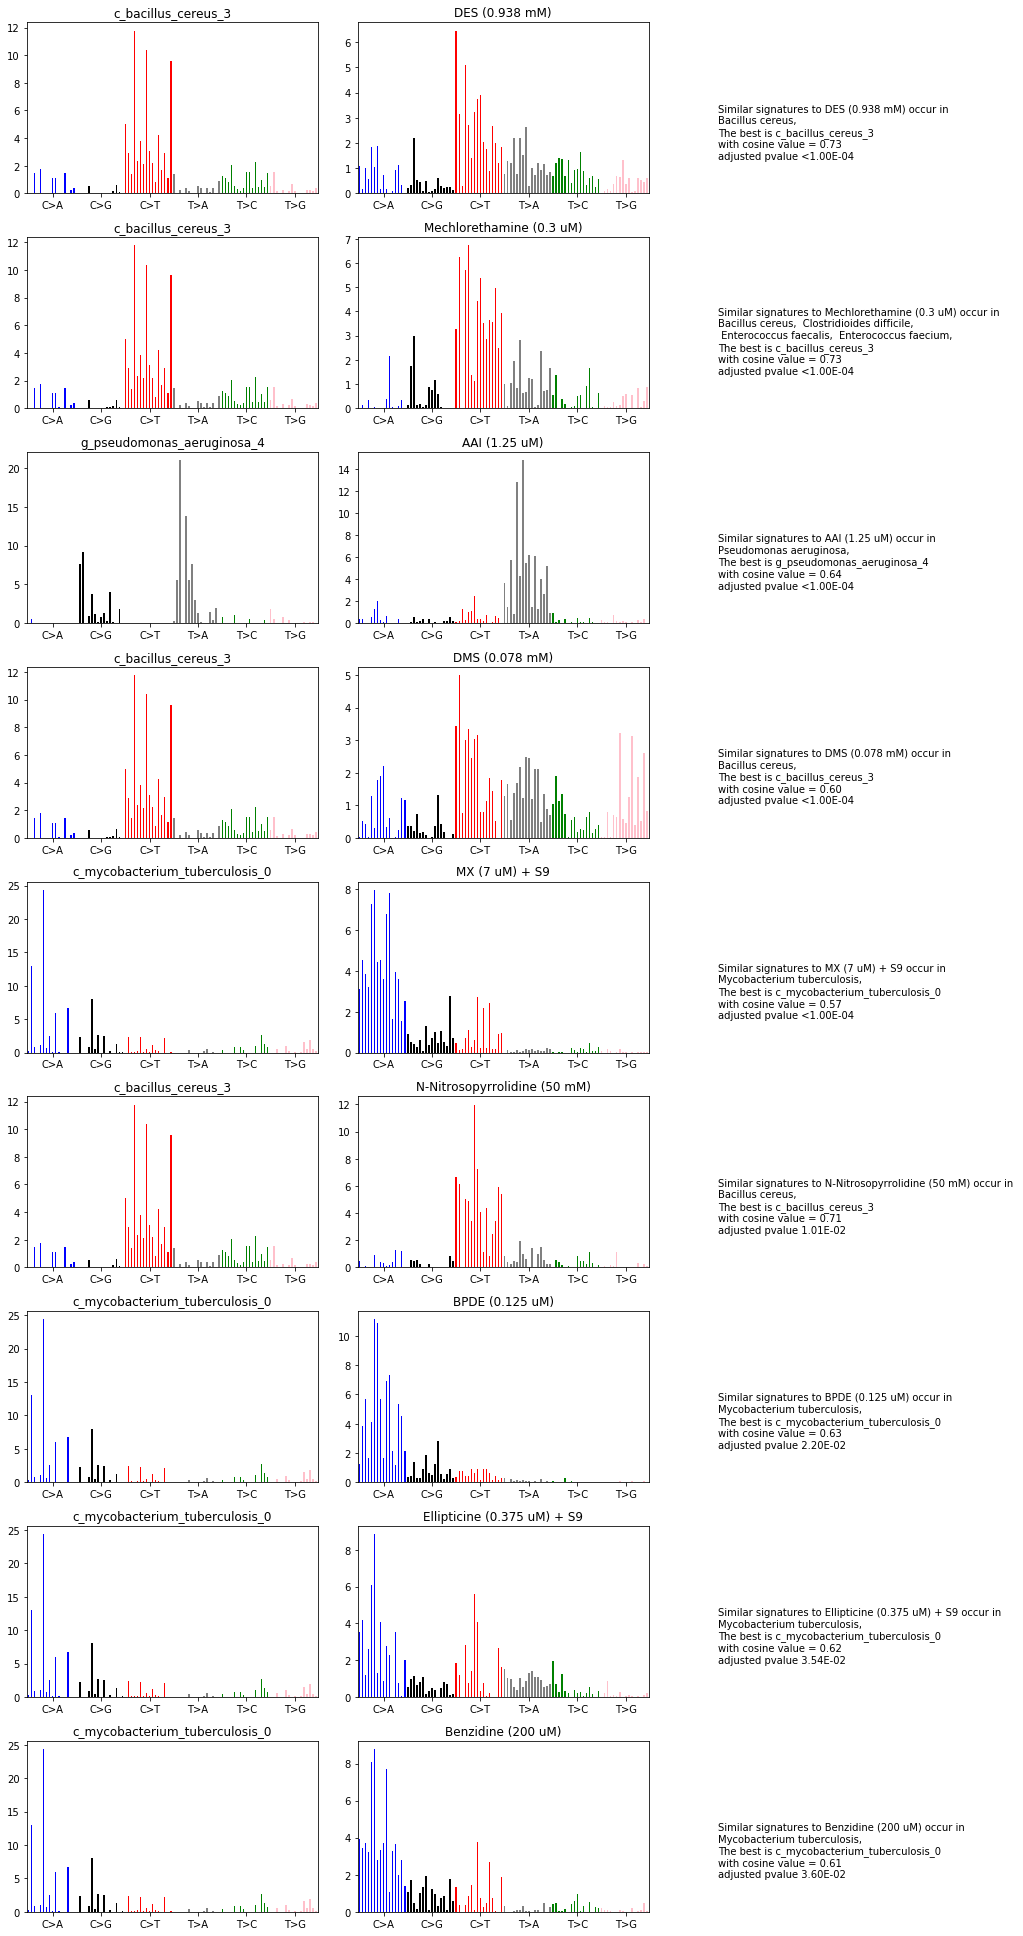

In [98]:
fig = show_stat_sig_mutagen(d,
                            tog_bacsigs*100,
                            mu_with_parsed_bacs,
                          start=8,stop=17)
fig.savefig(global_results_path('best_similarity_to_mutagens2.pdf'))